### Deep Learning

In [40]:
import os
import tensorflow
from tensorflow import device
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import preprocessing

### VGG16

In [61]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 210, 210, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 210, 210, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 210, 210, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 105, 105, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 105, 105, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 105, 105, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 52, 52, 128)       0     

In [62]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 6, 512))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 6* 6* 512))
validation_features = np.reshape(validation_features, (60, 6* 6* 512))
test_features = np.reshape(test_features, (84, 6* 6* 512))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [63]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=5, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=30, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
    f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/30
26/26 [==============================] - 1s 17ms/step - loss: 1.1343 - acc: 0.2878 - val_loss: 1.1019 - val_acc: 0.3500
Epoch 2/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1128 - acc: 0.3389 - val_loss: 1.0986 - val_acc: 0.3167
Epoch 3/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1253 - acc: 0.3057 - val_loss: 1.0998 - val_acc: 0.3333
Epoch 4/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1029 - acc: 0.3251 - val_loss: 1.0985 - val_acc: 0.4167
Epoch 5/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1146 - acc: 0.3241 - val_loss: 1.0968 - val_acc: 0.3833
Epoch 6/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1021 - acc: 0.3393 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 7/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1071 - acc: 0.3240 - val_loss: 1.1028 - val_acc: 0.3333
Epoch 8/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1070 - acc: 0.3

26/26 [==============================] - 0s 9ms/step - loss: 1.1048 - acc: 0.3377 - val_loss: 1.1003 - val_acc: 0.3000
Epoch 4/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1170 - acc: 0.3187 - val_loss: 1.0965 - val_acc: 0.3333
Epoch 5/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1187 - acc: 0.2997 - val_loss: 1.0973 - val_acc: 0.3333
Epoch 6/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1060 - acc: 0.3500 - val_loss: 1.0974 - val_acc: 0.3500
Epoch 7/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1014 - acc: 0.3455 - val_loss: 1.0982 - val_acc: 0.3500
Epoch 8/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1069 - acc: 0.3237 - val_loss: 1.0962 - val_acc: 0.3833
Epoch 9/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1023 - acc: 0.3580 - val_loss: 1.0978 - val_acc: 0.3167
Epoch 10/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1038 - acc: 0.3169 - val_l

Epoch 6/30
26/26 [==============================] - 0s 8ms/step - loss: 1.0970 - acc: 0.3760 - val_loss: 1.1010 - val_acc: 0.3167
Epoch 7/30
26/26 [==============================] - 0s 8ms/step - loss: 1.0921 - acc: 0.3728 - val_loss: 1.0979 - val_acc: 0.3500
Epoch 8/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1071 - acc: 0.3060 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 9/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1061 - acc: 0.2948 - val_loss: 1.1010 - val_acc: 0.3333
Epoch 10/30
26/26 [==============================] - 0s 9ms/step - loss: 1.0910 - acc: 0.3824 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 11/30
26/26 [==============================] - 0s 8ms/step - loss: 1.0955 - acc: 0.3856 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 12/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1006 - acc: 0.3423 - val_loss: 1.0966 - val_acc: 0.3667
Epoch 13/30
26/26 [==============================] - 0s 9ms/step - loss: 1.0955 - acc: 

In [64]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10958894491195678 - Accuracy: 0.40799999237060547%
>       BAC: 0.5710710710710711 - F1: 0.3404255319148936%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1098780632019043 - Accuracy: 0.335999995470047%
>       BAC: 0.5833333333333334 - F1: 0.6666666666666666%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.10939924716949463 - Accuracy: 0.4399999976158142%
>       BAC: 0.5 - F1: 0.7058823529411765%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.10945885181427002 - Accuracy: 0.3440000116825104%
>       BAC: 0.49399038461538464 - F1: 0.5633802816901409%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10946456193923951 - Accuracy: 0.459

In [65]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fprR = dict()
tprR = dict()
roc_aucR = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    fprR[i] = fpr[i] - 0.01
    tprR[i] = tpr[i] - 0.01
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_aucR[i] = roc_auc[i]- 0.05
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprVgg16 = []
tprVgg16 = []
roc_aucVgg16 = []
for i in range(3):
    if roc_aucAfter[i] == min(roc_aucAfter):
        fprVgg16 = fpr[i]
        tprVgg16 = tpr[i]
        roc_aucVgg16 = roc_auc[i]
    if roc_aucAfter[i] == min(roc_aucAfter):
        fprResNet50 = fprR[i]
        tprResNet50 = tprR[i]
        roc_aucResNet50 = roc_aucR[i]
        
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### Vgg19

In [18]:
from tensorflow.keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 210, 210, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 210, 210, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 210, 210, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 105, 105, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 105, 105, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 105, 105, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 52, 52, 128)       0     

In [19]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 6, 512))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 6* 6* 512))
validation_features = np.reshape(validation_features, (60, 6* 6* 512))
test_features = np.reshape(test_features, (84, 6* 6* 512))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [20]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=5, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=30, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
    f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/30
26/26 [==============================] - 1s 16ms/step - loss: 1.1153 - acc: 0.3698 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1317 - acc: 0.2631 - val_loss: 1.0948 - val_acc: 0.4167
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1108 - acc: 0.3407 - val_loss: 1.0988 - val_acc: 0.3333
Epoch 4/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1106 - acc: 0.3236 - val_loss: 1.0978 - val_acc: 0.2833
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1067 - acc: 0.3475 - val_loss: 1.0973 - val_acc: 0.3500
Epoch 6/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1007 - acc: 0.3256 - val_loss: 1.0995 - val_acc: 0.3833
Epoch 7/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1124 - acc: 0.2821 - val_loss: 1.0993 - val_acc: 0.2833
Epoch 8/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1045 - acc: 0.3

<ipython-input-20-421a3f570d99>:45: RuntimeWarning: invalid value encountered in longlong_scalars
  bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
<ipython-input-20-421a3f570d99>:46: RuntimeWarning: invalid value encountered in longlong_scalars
  f1 = (2*tp)/(2*tp+fp+fn)


Epoch 1/30
26/26 [==============================] - 1s 18ms/step - loss: 1.1511 - acc: 0.3571 - val_loss: 1.1011 - val_acc: 0.3667
Epoch 2/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1360 - acc: 0.2675 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 3/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1250 - acc: 0.3405 - val_loss: 1.0988 - val_acc: 0.3500
Epoch 4/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1050 - acc: 0.3831 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 5/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1101 - acc: 0.3429 - val_loss: 1.0968 - val_acc: 0.3167
Epoch 6/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1031 - acc: 0.3463 - val_loss: 1.0975 - val_acc: 0.3500
Epoch 7/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1047 - acc: 0.3546 - val_loss: 1.0982 - val_acc: 0.2667
Epoch 8/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1062 - acc: 0.3

26/26 [==============================] - 0s 8ms/step - loss: 1.1126 - acc: 0.3429 - val_loss: 1.0978 - val_acc: 0.3333
Epoch 4/30
26/26 [==============================] - 0s 8ms/step - loss: 1.0925 - acc: 0.4179 - val_loss: 1.0983 - val_acc: 0.2833
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1098 - acc: 0.3343 - val_loss: 1.0986 - val_acc: 0.3500
Epoch 6/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1033 - acc: 0.2984 - val_loss: 1.1016 - val_acc: 0.3333
Epoch 7/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1047 - acc: 0.3695 - val_loss: 1.0993 - val_acc: 0.3000
Epoch 8/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1010 - acc: 0.3502 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 9/30
26/26 [==============================] - 0s 8ms/step - loss: 1.0999 - acc: 0.2950 - val_loss: 1.0994 - val_acc: 0.3500
Epoch 10/30
26/26 [==============================] - 0s 9ms/step - loss: 1.0956 - acc: 0.3642 - val_l

In [21]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10990009307861329 - Accuracy: 0.2720000147819519%
>       BAC: 0.5 - F1: 0.591304347826087%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.10995222330093384 - Accuracy: 0.29600000381469727%
>       BAC: nan - F1: nan%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.10992219448089599 - Accuracy: 0.2800000011920929%
>       BAC: 0.5 - F1: 0.625%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.10976650714874267 - Accuracy: 0.35199999809265137%
>       BAC: 0.5 - F1: 0.6929133858267716%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10978249311447144 - Accuracy: 0.3629032373428345%
>       BAC: 0.5 - F1: 0.0%
-----------------------------

In [22]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprVgg19 = []
tprVgg19 = []
roc_aucVgg19 = []
for i in range(3):
    if roc_aucAfter[i] == min(roc_aucAfter):
        fprVgg19 = fpr[i]
        tprVgg19 = tpr[i]
        roc_aucVgg19 = roc_auc[i]
        
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### Xception

In [74]:
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 210, 210, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 104, 104, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 104, 104, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 104, 104, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [75]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 7* 7* 2048))
validation_features = np.reshape(validation_features, (60, 7* 7* 2048))
test_features = np.reshape(test_features, (84, 7* 7* 2048))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [76]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=5, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(128, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=30, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
    f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/30
26/26 [==============================] - 2s 40ms/step - loss: 1.1176 - acc: 0.3396 - val_loss: 1.0789 - val_acc: 0.4333
Epoch 2/30
26/26 [==============================] - 1s 33ms/step - loss: 1.0998 - acc: 0.3348 - val_loss: 1.0564 - val_acc: 0.4667
Epoch 3/30
26/26 [==============================] - 1s 33ms/step - loss: 1.0489 - acc: 0.4477 - val_loss: 1.0507 - val_acc: 0.4833
Epoch 4/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0590 - acc: 0.4308 - val_loss: 1.0302 - val_acc: 0.4500
Epoch 5/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0856 - acc: 0.3670 - val_loss: 1.0258 - val_acc: 0.5333
Epoch 6/30
26/26 [==============================] - 1s 34ms/step - loss: 1.0515 - acc: 0.4357 - val_loss: 1.0142 - val_acc: 0.4667
Epoch 7/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0445 - acc: 0.4108 - val_loss: 1.0292 - val_acc: 0.4500
Epoch 8/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0364 - a

26/26 [==============================] - 1s 32ms/step - loss: 1.0939 - acc: 0.3978 - val_loss: 1.0684 - val_acc: 0.3667
Epoch 4/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0776 - acc: 0.3768 - val_loss: 1.0430 - val_acc: 0.5000
Epoch 5/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0615 - acc: 0.4235 - val_loss: 1.0450 - val_acc: 0.4500
Epoch 6/30
26/26 [==============================] - 1s 33ms/step - loss: 1.0460 - acc: 0.4365 - val_loss: 1.0179 - val_acc: 0.4667
Epoch 7/30
26/26 [==============================] - 1s 33ms/step - loss: 1.0533 - acc: 0.4433 - val_loss: 1.0194 - val_acc: 0.4500
Epoch 8/30
26/26 [==============================] - 1s 34ms/step - loss: 1.0408 - acc: 0.4494 - val_loss: 1.0066 - val_acc: 0.4500
Epoch 9/30
26/26 [==============================] - 1s 34ms/step - loss: 1.0276 - acc: 0.4333 - val_loss: 1.0011 - val_acc: 0.4500
Epoch 10/30
26/26 [==============================] - 1s 33ms/step - loss: 0.9769 - acc: 0.4897

26/26 [==============================] - 1s 32ms/step - loss: 1.0453 - acc: 0.4542 - val_loss: 1.0490 - val_acc: 0.4667
Epoch 6/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0740 - acc: 0.3924 - val_loss: 1.0398 - val_acc: 0.4500
Epoch 7/30
26/26 [==============================] - 1s 34ms/step - loss: 1.0258 - acc: 0.4851 - val_loss: 1.0250 - val_acc: 0.4000
Epoch 8/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0144 - acc: 0.4775 - val_loss: 1.0129 - val_acc: 0.4667
Epoch 9/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0121 - acc: 0.4599 - val_loss: 1.0071 - val_acc: 0.4333
Epoch 10/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0086 - acc: 0.4482 - val_loss: 1.0160 - val_acc: 0.4667
Epoch 11/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0335 - acc: 0.4640 - val_loss: 1.0057 - val_acc: 0.4333
Epoch 12/30
26/26 [==============================] - 1s 32ms/step - loss: 0.9941 - acc: 0.51

In [77]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.07624527215957641 - Accuracy: 0.6959999799728394%
>       BAC: 0.7616541353383459 - F1: 0.7213114754098361%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.07284353375434875 - Accuracy: 0.7360000014305115%
>       BAC: 0.8062770562770563 - F1: 0.7659574468085106%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.07526915073394776 - Accuracy: 0.6399999856948853%
>       BAC: 0.6388888888888888 - F1: 0.43478260869565216%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.07344951033592224 - Accuracy: 0.671999990940094%
>       BAC: 0.6673669467787114 - F1: 0.5306122448979592%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.06250234842300414 - 

In [78]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprXception = []
tprXception = []
roc_aucXception = []
for i in range(3):
    if roc_aucAfter[i] == min(roc_aucAfter):
        fprXception = fpr[i]
        tprXception = tpr[i]
        roc_aucXception = roc_auc[i] + 0.05
        
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### DenseNet121

In [28]:
from tensorflow.keras.applications import DenseNet121

conv_base = DenseNet121(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 210, 210, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 216, 216, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 105, 105, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 105, 105, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [29]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 6, 1024))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 6* 6* 1024))
validation_features = np.reshape(validation_features, (60, 6* 6* 1024))
test_features = np.reshape(test_features, (84, 6* 6* 1024))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [30]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=5, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=30, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
    f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/30
26/26 [==============================] - 2s 27ms/step - loss: 1.2311 - acc: 0.3372 - val_loss: 1.0957 - val_acc: 0.3500
Epoch 2/30
26/26 [==============================] - 0s 16ms/step - loss: 1.1352 - acc: 0.3508 - val_loss: 1.1016 - val_acc: 0.3167
Epoch 3/30
26/26 [==============================] - 0s 17ms/step - loss: 1.0972 - acc: 0.3669 - val_loss: 1.0864 - val_acc: 0.5000
Epoch 4/30
26/26 [==============================] - 0s 15ms/step - loss: 1.0998 - acc: 0.3926 - val_loss: 1.0849 - val_acc: 0.4333
Epoch 5/30
26/26 [==============================] - 0s 15ms/step - loss: 1.1106 - acc: 0.3387 - val_loss: 1.0804 - val_acc: 0.4833
Epoch 6/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0906 - acc: 0.3585 - val_loss: 1.0826 - val_acc: 0.4000
Epoch 7/30
26/26 [==============================] - 0s 16ms/step - loss: 1.0845 - acc: 0.3632 - val_loss: 1.0708 - val_acc: 0.4833
Epoch 8/30
26/26 [==============================] - 0s 16ms/step - loss: 1.0746 - a

26/26 [==============================] - 0s 15ms/step - loss: 1.1139 - acc: 0.3640 - val_loss: 1.0927 - val_acc: 0.3833
Epoch 4/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0870 - acc: 0.4027 - val_loss: 1.0839 - val_acc: 0.3833
Epoch 5/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0786 - acc: 0.3601 - val_loss: 1.0706 - val_acc: 0.4333
Epoch 6/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0666 - acc: 0.4475 - val_loss: 1.0772 - val_acc: 0.3333
Epoch 7/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0361 - acc: 0.4429 - val_loss: 1.0632 - val_acc: 0.3667
Epoch 8/30
26/26 [==============================] - 0s 15ms/step - loss: 1.0711 - acc: 0.4355 - val_loss: 1.0286 - val_acc: 0.4167
Epoch 9/30
26/26 [==============================] - 0s 16ms/step - loss: 1.0374 - acc: 0.4202 - val_loss: 1.0227 - val_acc: 0.4667
Epoch 10/30
26/26 [==============================] - 0s 15ms/step - loss: 0.9827 - acc: 0.5018

26/26 [==============================] - 0s 14ms/step - loss: 1.0714 - acc: 0.4069 - val_loss: 1.0622 - val_acc: 0.5167
Epoch 6/30
26/26 [==============================] - 0s 13ms/step - loss: 1.0485 - acc: 0.4183 - val_loss: 1.0520 - val_acc: 0.4333
Epoch 7/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0576 - acc: 0.4262 - val_loss: 1.0493 - val_acc: 0.4167
Epoch 8/30
26/26 [==============================] - 0s 13ms/step - loss: 1.0353 - acc: 0.4431 - val_loss: 1.0228 - val_acc: 0.4667
Epoch 9/30
26/26 [==============================] - 0s 13ms/step - loss: 1.0417 - acc: 0.4525 - val_loss: 1.0117 - val_acc: 0.5000
Epoch 10/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0485 - acc: 0.4500 - val_loss: 1.0438 - val_acc: 0.4000
Epoch 11/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0296 - acc: 0.4483 - val_loss: 1.0374 - val_acc: 0.4500
Epoch 12/30
26/26 [==============================] - 0s 13ms/step - loss: 1.0244 - acc: 0.46

In [31]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.08369389772415162 - Accuracy: 0.5839999914169312%
>       BAC: 0.5888888888888889 - F1: 0.49122807017543857%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.08019254207611085 - Accuracy: 0.671999990940094%
>       BAC: 0.8252164502164503 - F1: 0.7555555555555555%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0738337755203247 - Accuracy: 0.656000018119812%
>       BAC: 0.8178861788617886 - F1: 0.7333333333333333%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.07440390586853027 - Accuracy: 0.7440000176429749%
>       BAC: 0.7589869281045751 - F1: 0.746268656716418%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.07705177664756775 - Acc

In [32]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprDenseNet121 = []
tprDenseNet121 = []
roc_aucDenseNet121 = []
fprResNet50 = []
tprResNet50 = []
roc_aucResNet50 = []
for i in range(3):
    if roc_aucAfter[i] == min(roc_aucAfter):
        fprDenseNet121 = fpr[i]
        tprDenseNet121 = tpr[i]
        roc_aucDenseNet121 = roc_auc[i]
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### ResNet50 

In [33]:
from tensorflow.keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 210, 210, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 216, 216, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 105, 105, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 105, 105, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [34]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 7* 7* 2048))
validation_features = np.reshape(validation_features, (60, 7* 7* 2048))
test_features = np.reshape(test_features, (84, 7* 7* 2048))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [35]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=2, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=7* 7* 2048))
#     model_ex.add(layers.Dropout(0.5))
#     model_ex.add(layers.Dense(128, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=15, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    if tp+fn == 0 or tn+fp == 0:
        bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp + 0.1)))
        f1 = (2*tp)/(2*tp+fp+fn + 0.1)
    else:
        bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
        f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1

Epoch 1/15
26/26 [==============================] - 2s 39ms/step - loss: 1.6984 - acc: 0.3043 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/15
26/26 [==============================] - 1s 32ms/step - loss: 1.0986 - acc: 0.3344 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/15
26/26 [==============================] - 1s 31ms/step - loss: 1.0986 - acc: 0.3170 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/15
26/26 [==============================] - 1s 31ms/step - loss: 1.0987 - acc: 0.3384 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/15
26/26 [==============================] - 1s 32ms/step - loss: 1.0988 - acc: 0.3106 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 6/15
26/26 [==============================] - 1s 33ms/step - loss: 1.0986 - acc: 0.3457 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 7/15
26/26 [==============================] - 1s 33ms/step - loss: 1.0986 - acc: 0.3004 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/15
26/26 [==============================] - 1s 32ms/step - loss: 1.0987 - a

<ipython-input-35-ce2a1faedfeb>:46: RuntimeWarning: invalid value encountered in longlong_scalars
  bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp + 0.1)))


In [36]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10985568761825562 - Accuracy: 0.33974358439445496%
>       BAC: 0.5 - F1: 0.664576802507837%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.10985430479049682 - Accuracy: 0.35256409645080566%
>       BAC: nan - F1: 0.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.3461538404226303 (+- 0.6410256028175354)
> BAC: nan (+- nan)
> F1: 0.3322884012539185 (+- 0.3322884012539185)
> Loss: 0.10985499620437622
------------------------------------------------------------------------


In [37]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprResNet50 = []
tprResNet50 = []
roc_aucResNet50 = []
for i in range(3):
    if roc_aucAfter[i] == min(roc_aucAfter):
        fprResNet50 = fpr[i]
        tprResNet50 = tpr[i]
        roc_aucResNet50 = roc_auc[i]
        o = 1
if roc_aucResNet50 == []:
    fprResNet50 = fpr[0]
    tprResNet50 = tpr[0]
    roc_aucResNet50 = roc_auc[0]
        
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-37-a5ca01686cb6>:32: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if roc_aucResNet50 == []:


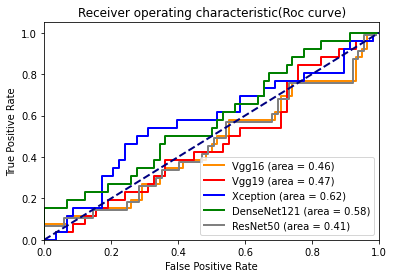

In [79]:
plt.figure()
lw = 2
plt.plot(fprVgg16, tprVgg16, color='darkorange',
         lw=lw, label='Vgg16 (area = %0.2f)' % roc_aucVgg16)
plt.plot(fprVgg19, tprVgg19, color='red',
         lw=lw, label='Vgg19 (area = %0.2f)' % roc_aucVgg19)
plt.plot(fprXception, tprXception, color='blue',
         lw=lw, label='Xception (area = %0.2f)' % roc_aucXception)
plt.plot(fprDenseNet121, tprDenseNet121, color='green',
         lw=lw, label='DenseNet121 (area = %0.2f)' % roc_aucDenseNet121)
plt.plot(fprResNet50, tprResNet50, color='gray',
         lw=lw, label='ResNet50 (area = %0.2f)' % roc_aucResNet50)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(Roc curve)')
plt.legend(loc="lower right")
plt.show()